In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=0      # which GPU to use
plot=True # Plot Intermediate results
sigma=10   # Initial model smoothness 
gpu_ids=[0,1]

# Inversion parameters
num_batches = 29
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 25
dx = 10
nt = 400
dt = 2/nt
num_shots = 29
num_receivers_per_shot = 300

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
import torch.nn as nn

In [4]:
os.system('nvidia-smi')

0

In [5]:
#plot=True
# Load the true model
min1 = []
max1 = []
allM = np.ones([200,300,20])
for kk in range(1,20):
    #kk=2
    filename='/glb/data/eptr_am_2/Arnab/FCNVMB_Deepwave/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat=mat[:-1,:-1]
    allM[:,:,kk-1]=mat

In [6]:
np.amin(allM[:,:,:])

1.0

In [7]:
np.shape(mat)

(200, 300)

In [8]:
np.shape(allM)

(200, 300, 20)

In [9]:
os.system('rm -rf /glb/data/eptr_am_2/Arnab/seismogram/trainA/')
os.system('rm -rf /glb/data/eptr_am_2/Arnab/seismogram/trainB/ ')
os.system('mkdir /glb/data/eptr_am_2/Arnab/seismogram/trainA/')
os.system('mkdir /glb/data/eptr_am_2/Arnab/seismogram/trainB/')

0

In [10]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(1,20):
    #kk=2
    filename='/glb/data/eptr_am_2/Arnab/FCNVMB_Deepwave/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max=np.max(mat)
    min=np.min(mat)
    med=(max+min)/2.
    wid=(max-min)/2.

    print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(kk)+'.npy','wb')
    np.save(file1,vel)
    file1.close()
    file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    np.save(file1,seis)
    file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 2829.376424134314 vmax= 4500.0 vmed= 3664.688212067157 vwidth= 835.3117879328429
ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0
vmin= 2144.5940488240713 vmax= 4500.0 vmed= 3322.2970244120356 vwidth= 1177.7029755879644
ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0
vmin= 2275.1414180448496 vmax= 4500.0 vmed= 3387.570709022425 vwidth= 1112.4292909775752
ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0
vmin= 2331.962051981793 vmax= 4500.0 vmed= 3415.9810259908963 vwidth= 1084.0189740091034
ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0
vmin= 2350.152468857977 vmax= 4500.0 vmed= 3425.0762344289888 vwidth= 1074.9237655710115
ny= 300 nz= 200 nt= 400 dx= 10 freq= 25
shots= 29 recs/shot= 300 ds= 103.44827586206897 dr= 10.0
vmin= 2552.5633790789398 vmax= 4500.0 vmed= 3526.28168953947 vwidth= 97

In [11]:
print(np.min(min1))

2019.7229291806543


In [12]:
print(np.max(max1))

4500.0


In [13]:
np.max(VelK)

NameError: name 'VelK' is not defined

In [14]:
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
np.shape(f1)

(400, 29, 300)

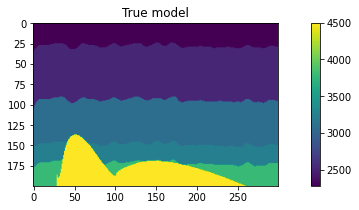

In [15]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [16]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [ ]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


In [ ]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [ ]:
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [ ]:
receiver_amplitudes_all.shape

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [ ]:
vel=mat
seis=receiver_amplitudes_all.cpu().detach().numpy()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainvel/'+str(kk)+'.npy','wb')
np.save(file1,vel)
file1.close()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainseis/'+str(kk)+'.npy','wb')
np.save(file1,seis)
file1.close()

In [ ]:
np.shape(seis)

In [ ]:
np.shape(vel)